<h1>Preprocessing PDMC N Panel</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
nexp = FCSExperiment.objects(experiment_id='PD_N_PDMCs').get()

In [4]:
nexp.list_samples()

['142-09_pdmc_n',
 '209-05_pdmc_n',
 '210-14_pdmc_n',
 '239-02_pdmc_n',
 '239-04_pdmc_n',
 '251-07_pdmc_n',
 '251-08_pdmc_n',
 '254-04_pdmc_n',
 '254-05_pdmc_n',
 '255-04_pdmc_n',
 '255-05_pdmc_n',
 '264-02_pdmc_n',
 '267-02_pdmc_n',
 '273-01_pdmc_n',
 '276-01_pdmc_n',
 '286-03_pdmc_n',
 '286-04_pdmc_n',
 '294-02_pdmc_n',
 '294-03_pdmc_n',
 '298-01_pdmc_n',
 '305-01_pdmc_n',
 '305-02_pdmc_n',
 '305-03_pdmc_n',
 '306-01_pdmc_n',
 '308-01_pdmc_n',
 '308-02R_pdmc_n',
 '308-03R_pdmc_n',
 '310-01_pdmc_n',
 '315-01_pdmc_n',
 '315-02_pdmc_n',
 '318-01_pdmc_n',
 '320-01_pdmc_n',
 '321-01_pdmc_n',
 '322-01_pdmc_n',
 '323-01_pdmc_n',
 '324-01_pdmc_n',
 '326-01_pdmc_n',
 '237-06_pdmc_n',
 '267-01_pdmc_n',
 '279-03_pdmc_n',
 '286-02_pdmc_n',
 '288-02_pdmc_n',
 '302-01_pdmc_n']

<h2>Create a Template</h2>

We will use the automated gates to isolate single Live CD45+ cells (all leukocytes).

In [7]:
n = Template(nexp, '142-09_pdmc_n')

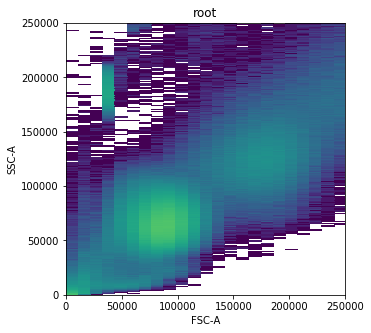

In [8]:
n.plotting.plot_population('root', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

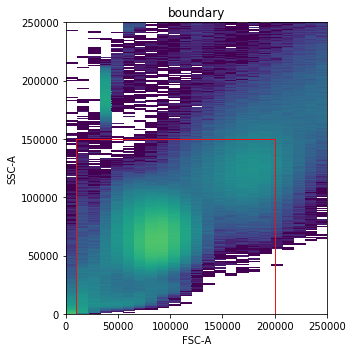

In [10]:
children = ChildPopulationCollection('geom')
children.add_population('cells', definition='+')
children.add_population('debris', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             x_min=10000, y_min=0, x_max=200000, y_max=150000)
n.create_gate(gate_name='boundary', 
              parent='root',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
n.apply('boundary')

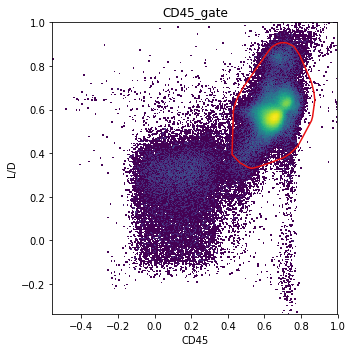

In [30]:
children = ChildPopulationCollection('cluster')
children.add_population('CD45+', target=(0.6, 0.6), weight=1)
kwargs = dict(x='CD45', y='L/D', transform_x='logicle', 
              transform_y='logicle', min_pop_size=100, frac=0.01)
n.create_gate(gate_name='CD45_gate', 
              parent='cells',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)
n.apply('CD45_gate')

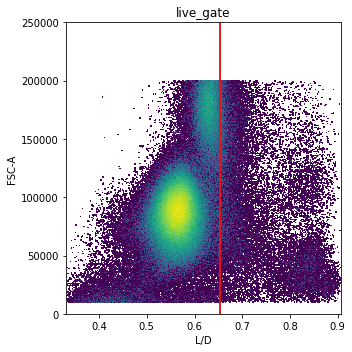

In [33]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('dead', definition='+')
children.add_population('Live_CD45+', definition='-')
kwargs = dict(x='L/D', transform_x='logicle', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
n.create_gate(gate_name='live_gate', 
              parent='CD45+',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('live_gate')

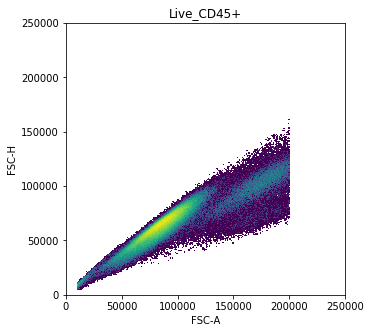

In [34]:
n.plotting.plot_population('Live_CD45+', 'FSC-A', 'FSC-H', transforms={'x':None,
                                                                       'y':None})

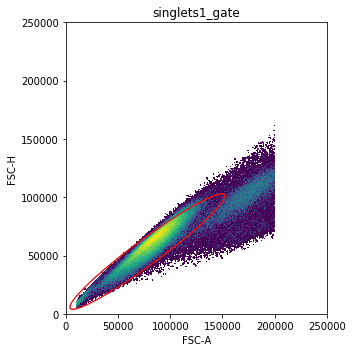

In [35]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
n.create_gate(gate_name='singlets1_gate', 
              parent='Live_CD45+',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
n.apply('singlets1_gate')

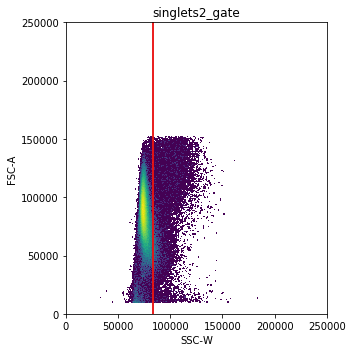

In [37]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('doublets2', definition='+')
children.add_population('Single_Live_CD45+', definition='-')
kwargs = dict(x='SSC-W', transform_x=None, kde_bw=5000, low_memory=True,
             ignore_double_pos=False, peak_threshold=0.05)
n.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('singlets2_gate')

In [38]:
n.print_population_tree()

root
├── cells
│   └── CD45+
│       ├── dead
│       └── Live_CD45+
│           ├── singlets1
│           │   ├── doublets2
│           │   └── Single_Live_CD45+
│           └── doublets1
└── debris


In [40]:
n.clean('Single_Live_CD45+')

In [41]:
n.populations['Single_Live_CD45+_cleaned'].prop_of_parent

0.9751692031698259

In [42]:
n.save_new_template('PDMCn_Preprocessing', overwrite=True)

No existing template named PDMCn_Preprocessing, creating new template


True

<h3>Secondary template</h3>

In [143]:
n = Template(nexp, '254-05_pdmc_n')

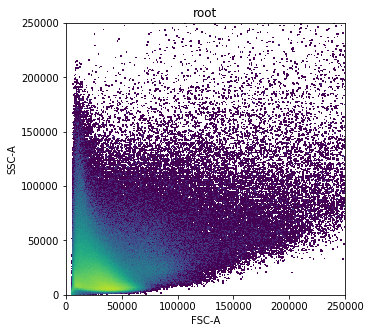

In [152]:
n.plotting.plot_population('root', 'FSC-A', 'SSC-A', transforms={'x':None, 'y':None})

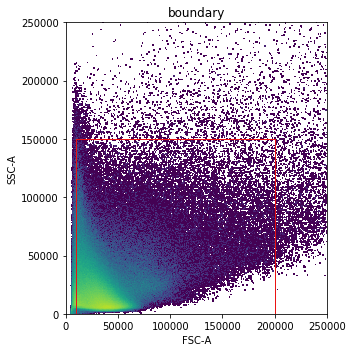

In [153]:
children = ChildPopulationCollection('geom')
children.add_population('cells', definition='+')
children.add_population('debris', definition='-')
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None,
             x_min=10000, y_min=0, x_max=200000, y_max=150000)
n.create_gate(gate_name='boundary', 
              parent='root',
              class_='Static',
              method='rect_gate',
              child_populations=children, 
              kwargs=kwargs)
n.apply('boundary')

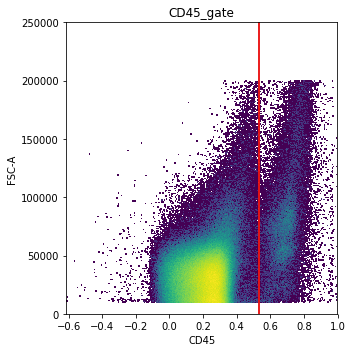

In [154]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('CD45+', definition='+')
children.add_population('CD45-', definition='-')
kwargs = dict(x='CD45', transform_x='logicle', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
n.create_gate(gate_name='CD45_gate', 
              parent='cells',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('CD45_gate')

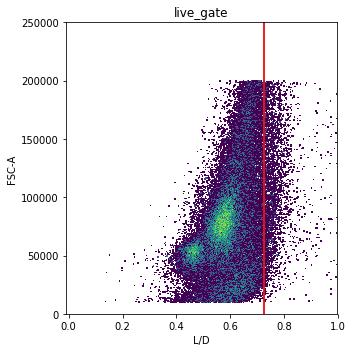

In [155]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('dead', definition='+')
children.add_population('Live_CD45+', definition='-')
kwargs = dict(x='L/D', transform_x='logicle', kde_bw=0.05, low_memory=True, peak_threshold=0.05)
n.create_gate(gate_name='live_gate', 
              parent='CD45+',
              class_='DensityThreshold',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('live_gate')

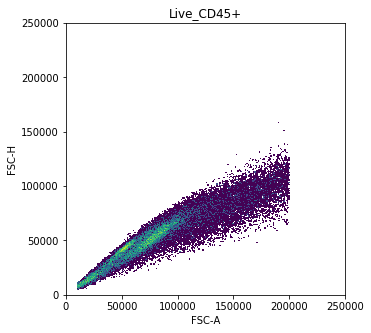

In [156]:
n.plotting.plot_population('Live_CD45+', 'FSC-A', 'FSC-H', transforms={'x':None,
                                                                       'y':None})

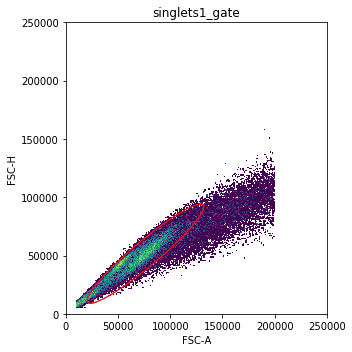

In [157]:
children = ChildPopulationCollection('geom')
children.add_population('singlets1', definition='+')
children.add_population('doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
n.create_gate(gate_name='singlets1_gate', 
              parent='Live_CD45+',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)
n.apply('singlets1_gate')

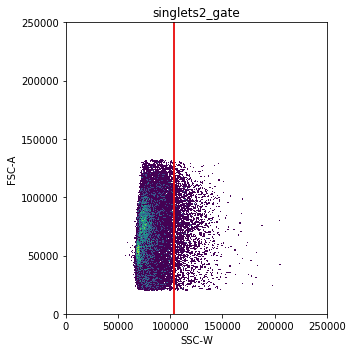

In [158]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('doublets2', definition='+')
children.add_population('Single_Live_CD45+', definition='-')
kwargs = dict(x='SSC-W', transform_x=None, q=0.95)
n.create_gate(gate_name='singlets2_gate', 
              parent='singlets1',
              class_='Quantile',
              method='gate_1d',
              child_populations=children, 
              kwargs=kwargs)
n.apply('singlets2_gate')

In [159]:
n.print_population_tree()

root
├── cells
│   ├── CD45+
│   │   ├── dead
│   │   └── Live_CD45+
│   │       ├── singlets1
│   │       │   ├── doublets2
│   │       │   └── Single_Live_CD45+
│   │       └── doublets1
│   └── CD45-
└── debris


In [160]:
n.clean('Single_Live_CD45+')

In [161]:
n.populations['Single_Live_CD45+_cleaned'].prop_of_parent

0.9715964929183929

In [162]:
n.save_new_template('PDMCn_Preprocessing_Secondary', overwrite=True)

Overwriting existing gating template PDMCn_Preprocessing_Secondary


True

<h2>Apply the preprocessing template to all samples</h2>

In [5]:
samples = nexp.list_samples()

In [7]:
for x in samples:
    n = Template(nexp, x)
    if 'cells' in n.populations.keys():
        n.remove_population('cells')
        n.remove_population('debris')
        n.save(overwrite=True)

Saved successfully!
Saved successfully!
Saved successfully!


In [8]:
def apply_template(sample_id, template='secondary'):
    print(f'------------------ {sample_id} ------------------')
    n = Template(nexp, sample_id)
    if template == 'secondary':
        n.load_template('PDMCn_Preprocessing_Secondary')
    else:
        n.load_template('PDMCn_Preprocessing')
    n.apply_many(apply_all=True, plot_outcome=True)
    return n

------------------ 142-09_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


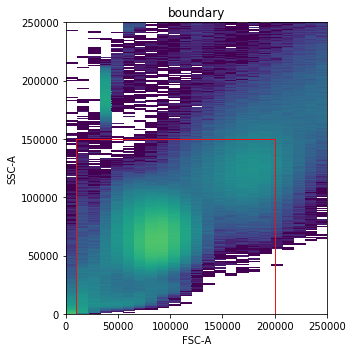

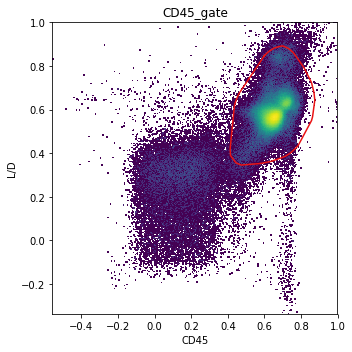

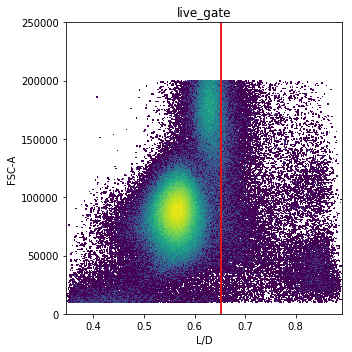

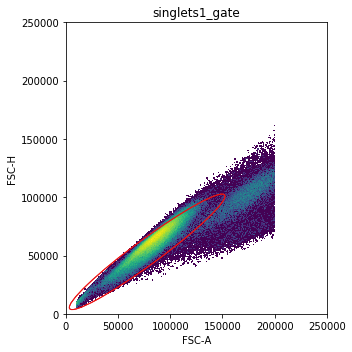

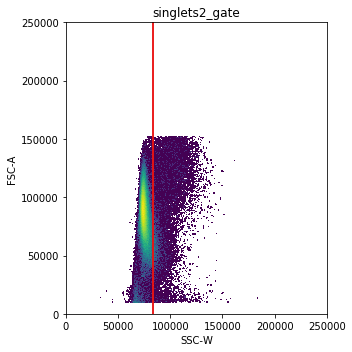

In [9]:
n = apply_template(samples[0], template='primary')

In [10]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 209-05_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


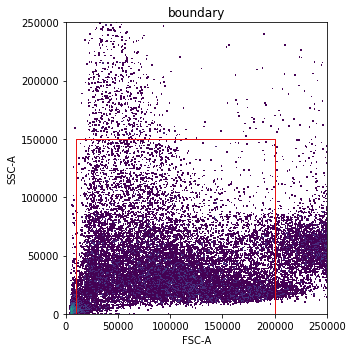

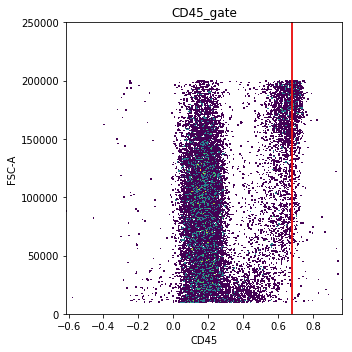

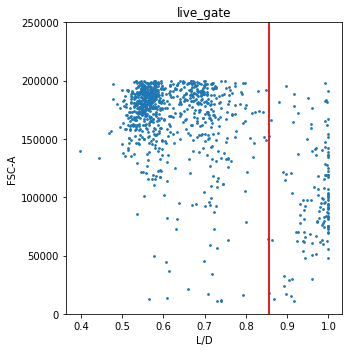

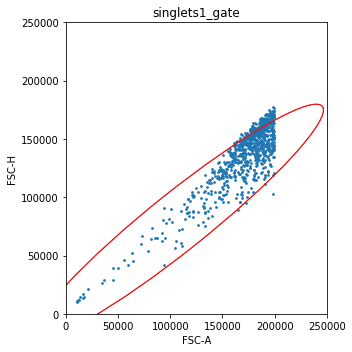

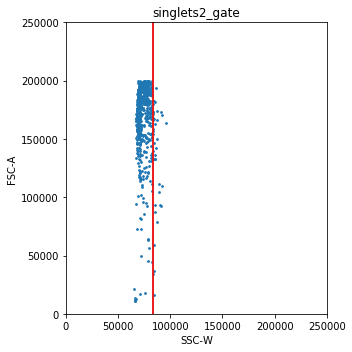

In [11]:
n = apply_template(samples[1])

In [12]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 210-14_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


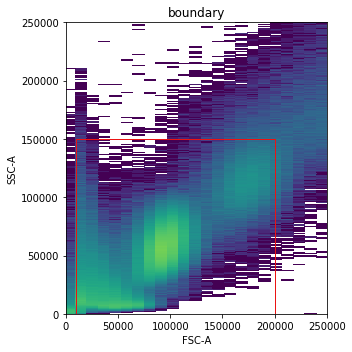

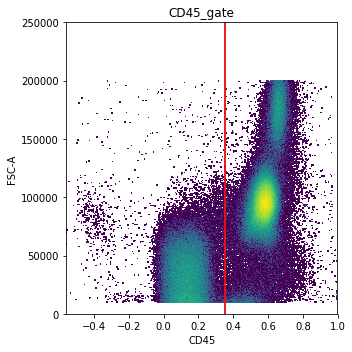

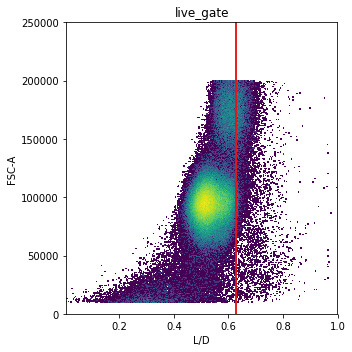

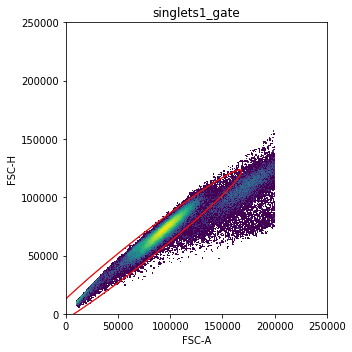

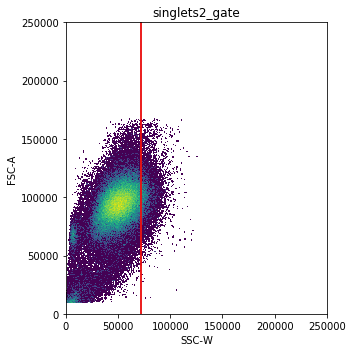

In [13]:
n = apply_template(samples[2])

In [14]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 239-02_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


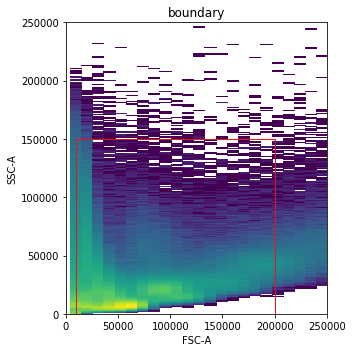

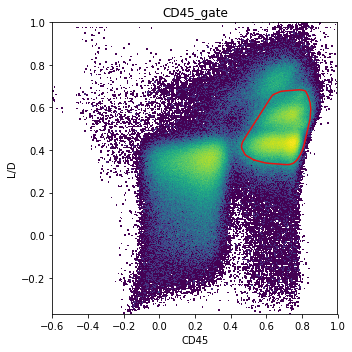

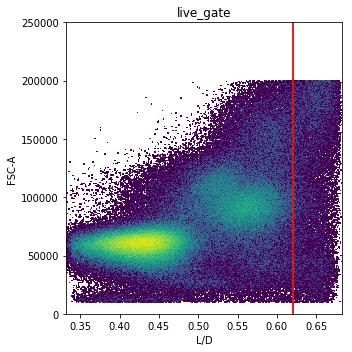

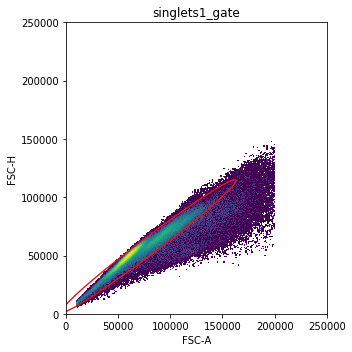

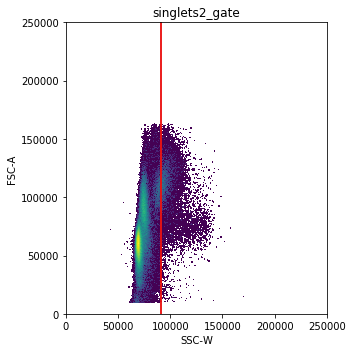

In [15]:
n = apply_template(samples[3], template='primary')

In [16]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 239-04_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


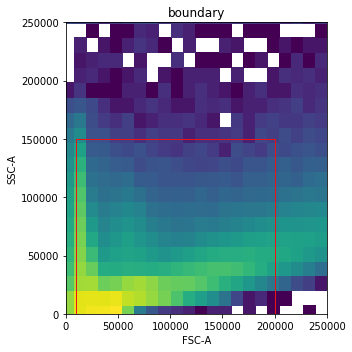

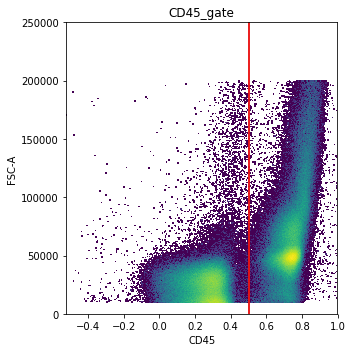

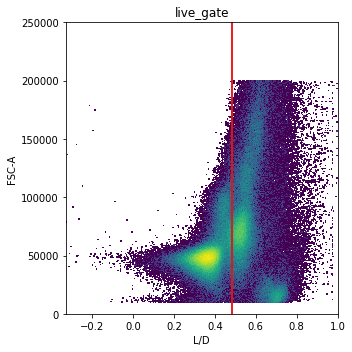

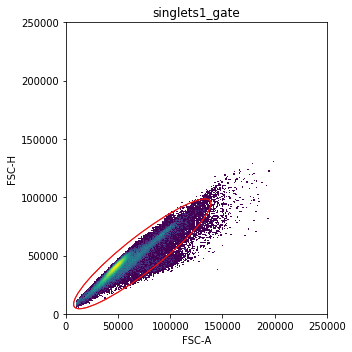

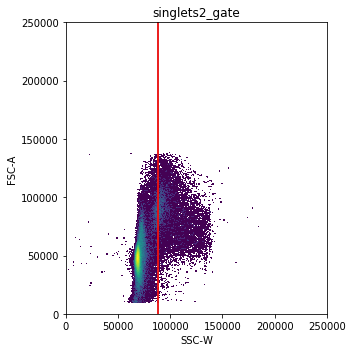

In [17]:
n = apply_template(samples[4])

In [18]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 251-07_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Applying CD45_gate2...
Error: population CD45- already exists, if you wish to overwrite this population please remove it with the remove_population method and then try again
Complete!


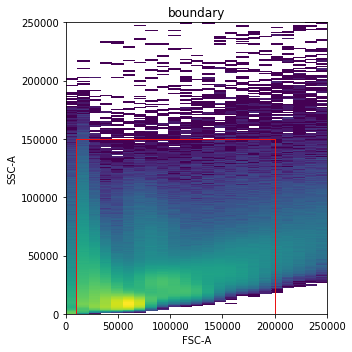

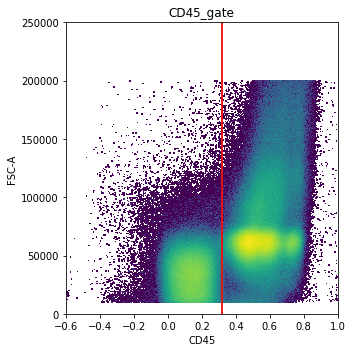

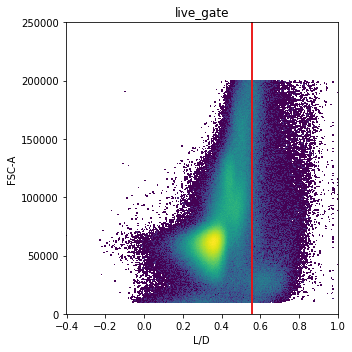

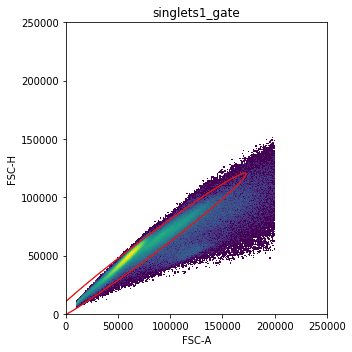

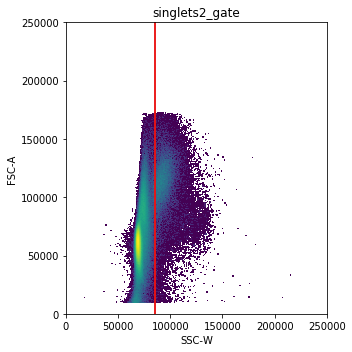

In [19]:
n = apply_template(samples[5])

In [20]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 251-08_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


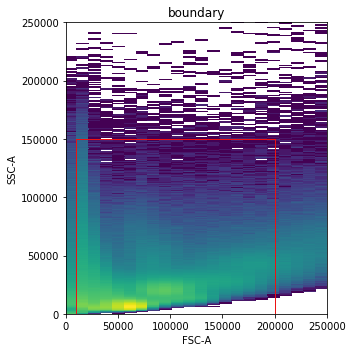

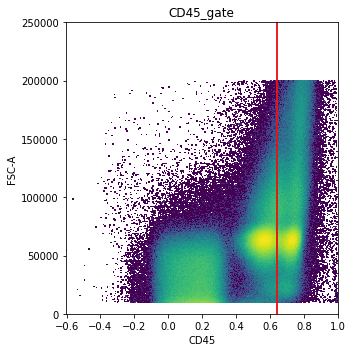

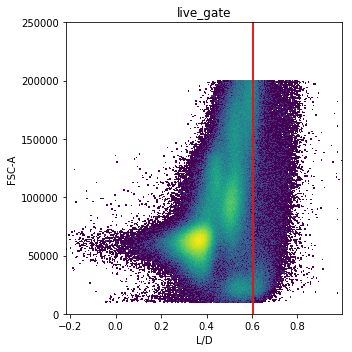

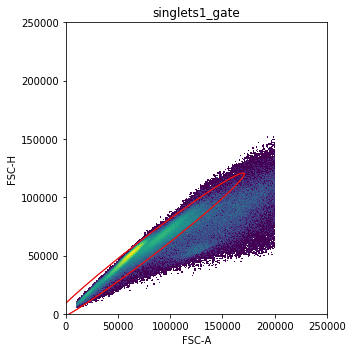

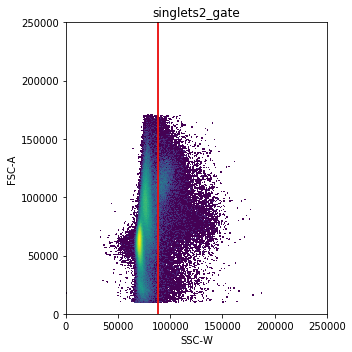

In [21]:
n = apply_template(samples[6])

In [22]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 254-04_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


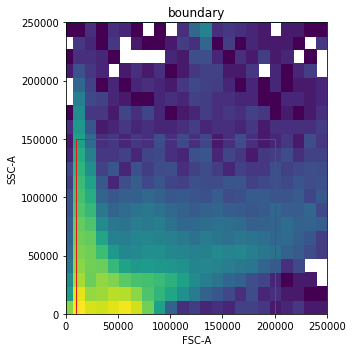

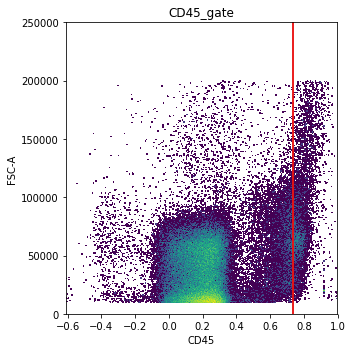

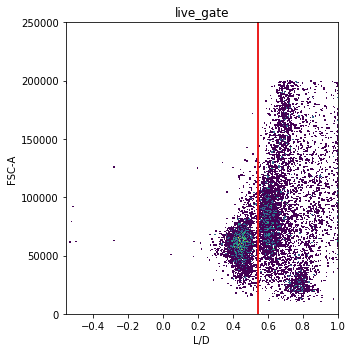

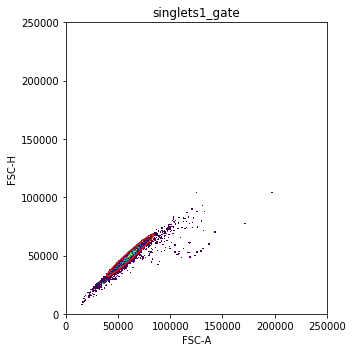

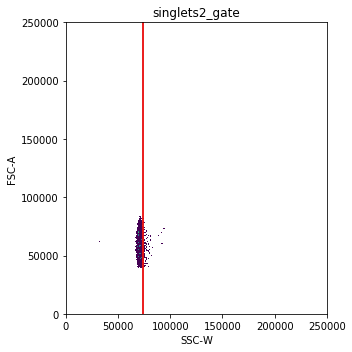

In [23]:
n = apply_template(samples[7])

In [98]:
n.clean('Single_Live_CD45+')
n.save()

Saved successfully!


True

------------------ 254-05_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


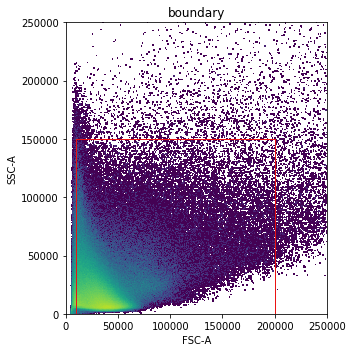

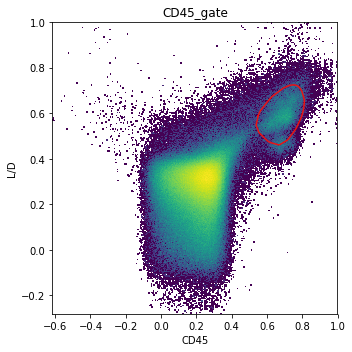

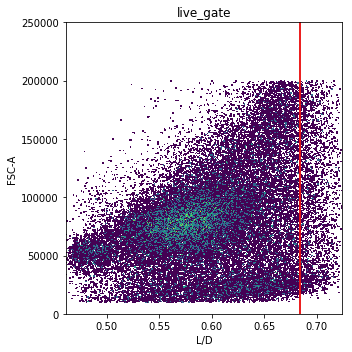

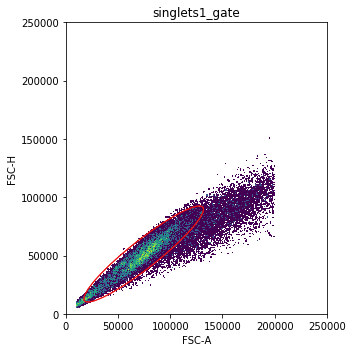

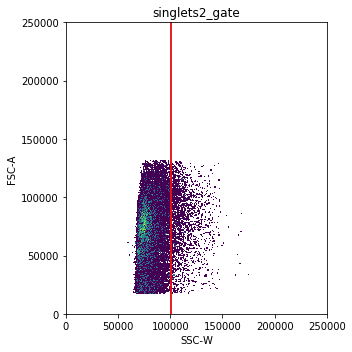

In [99]:
n = apply_template(samples[8])

------------------ 254-05_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


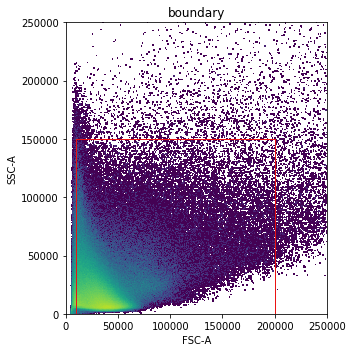

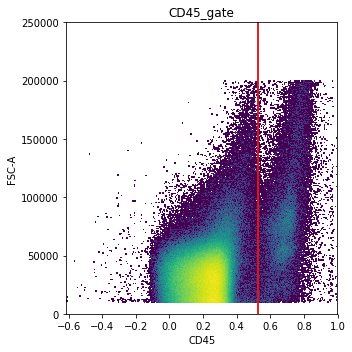

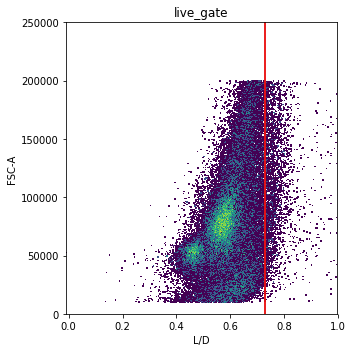

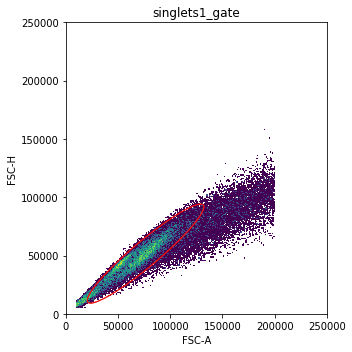

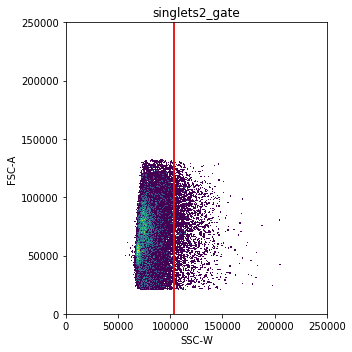

In [113]:
n = apply_template(samples[8], template='secondary')

In [114]:
n.clean('Single_Live_CD45+')
n.save()

Saved successfully!


True

------------------ 255-04_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


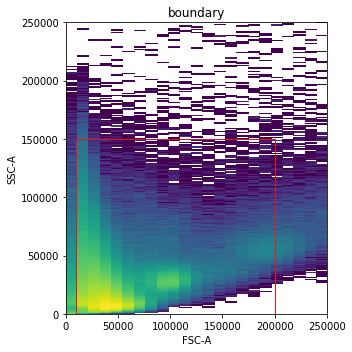

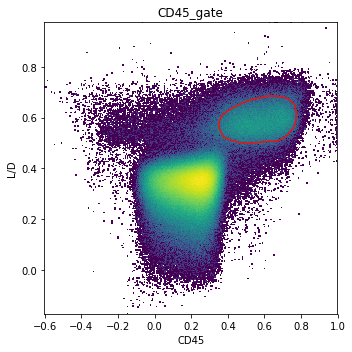

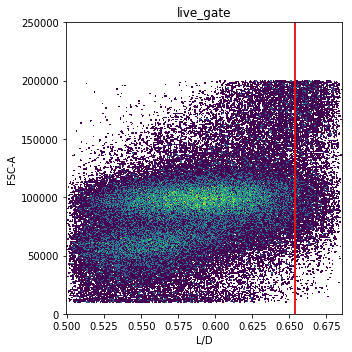

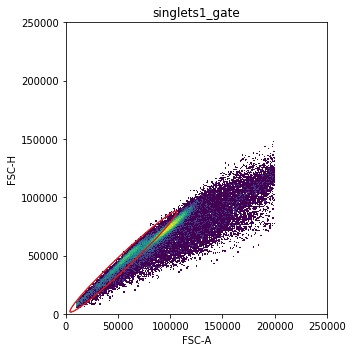

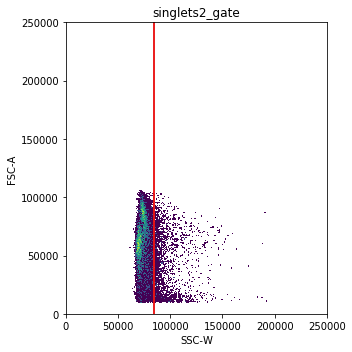

In [115]:
n = apply_template(samples[9])

In [116]:
n.clean('Single_Live_CD45+')
n.save()

Saved successfully!


True

------------------ 255-05_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


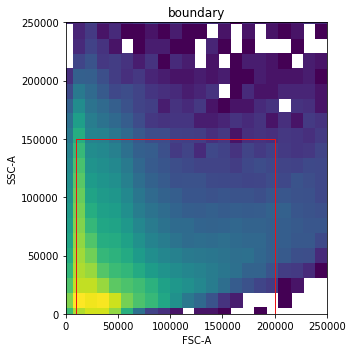

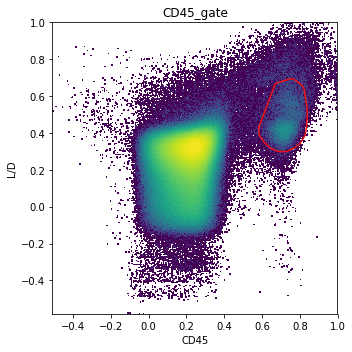

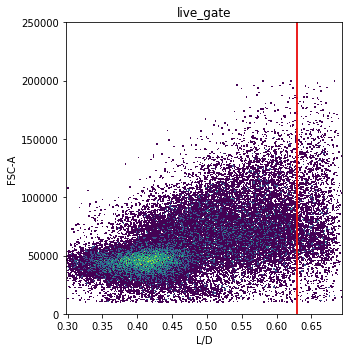

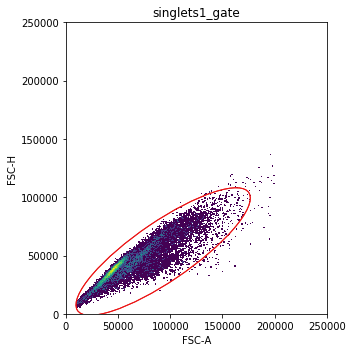

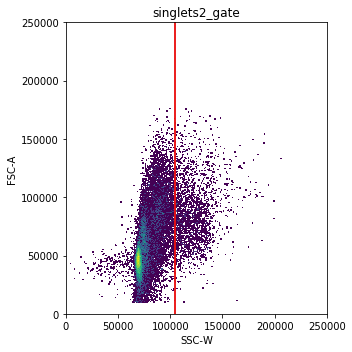

In [117]:
n = apply_template(samples[10])

------------------ 255-05_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


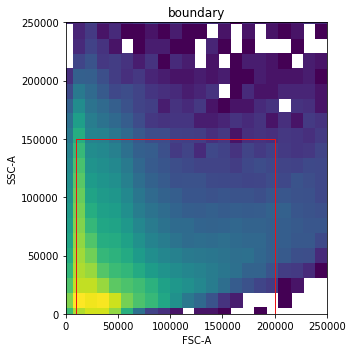

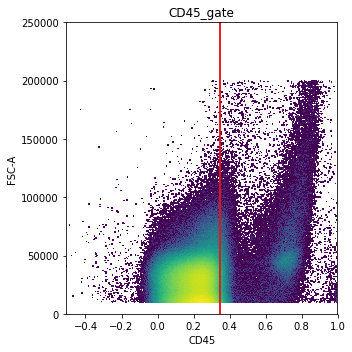

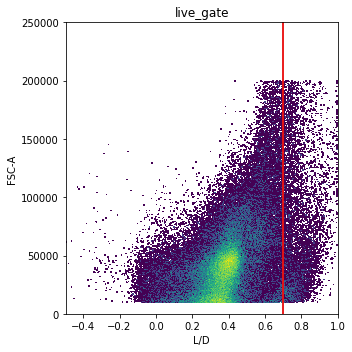

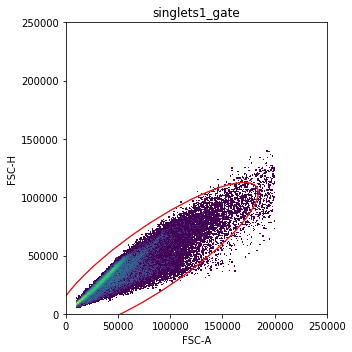

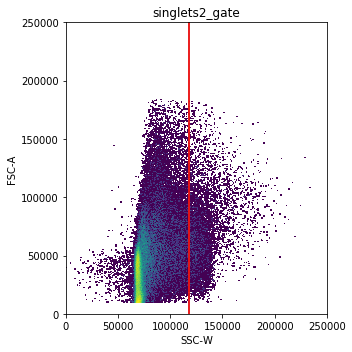

In [118]:
n = apply_template(samples[10], template='secondary')

In [119]:
n.clean('Single_Live_CD45+')
n.save()

Saved successfully!


True

------------------ 264-02_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


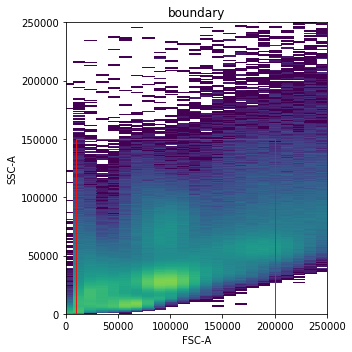

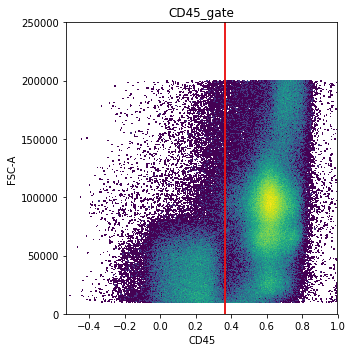

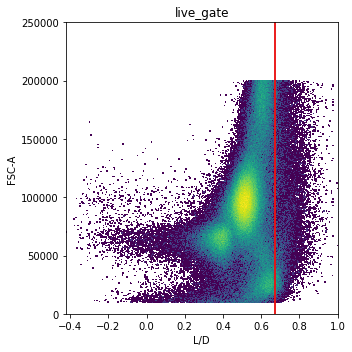

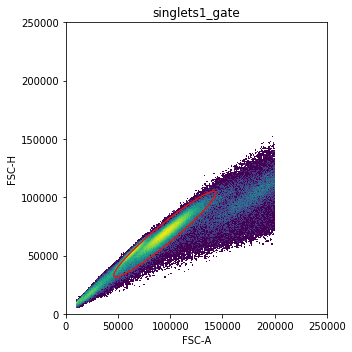

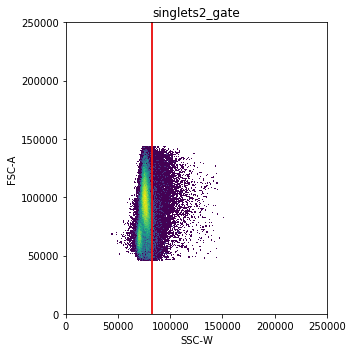

In [25]:
n = apply_template(samples[11], template='secondary')

In [27]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 267-02_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


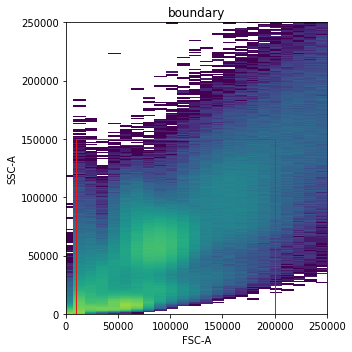

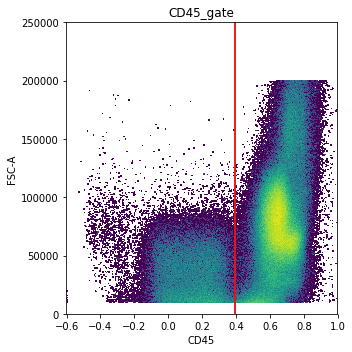

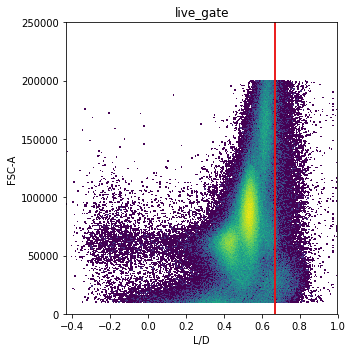

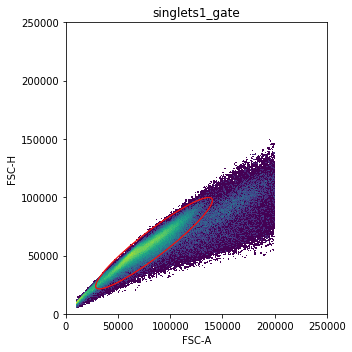

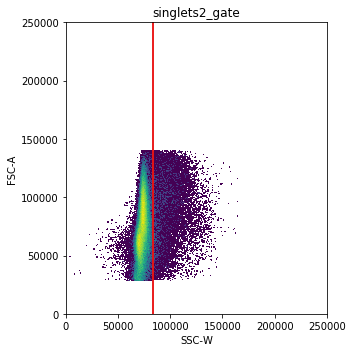

In [28]:
n = apply_template(samples[12], template='secondary')

In [29]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 273-01_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


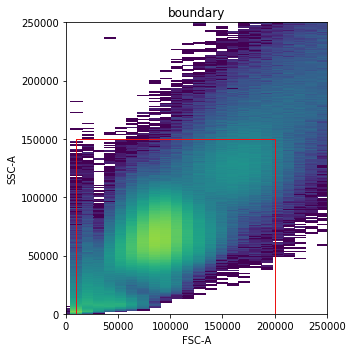

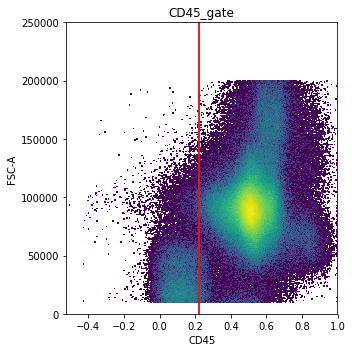

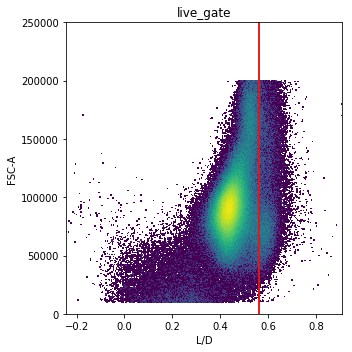

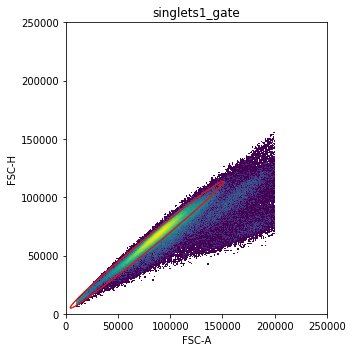

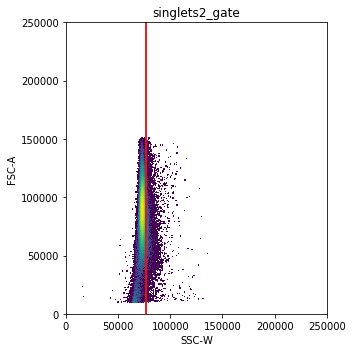

In [30]:
n = apply_template(samples[13])

In [31]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

Saved successfully!


True

------------------ 276-01_pdmc_n ------------------
Applying boundary...
Applying CD45_gate...
Applying live_gate...
Applying singlets1_gate...
Applying singlets2_gate...
Complete!


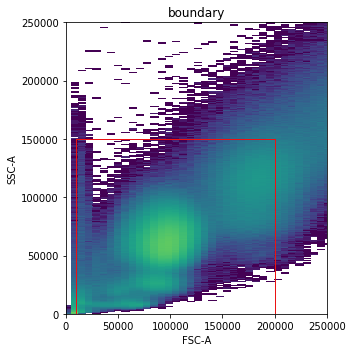

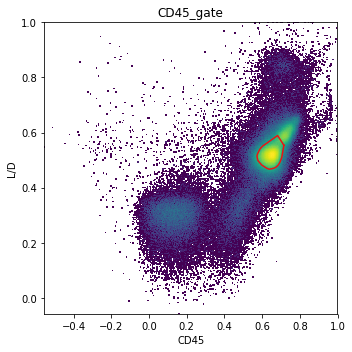

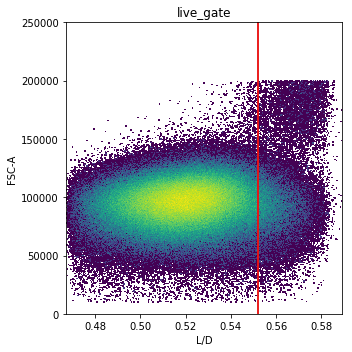

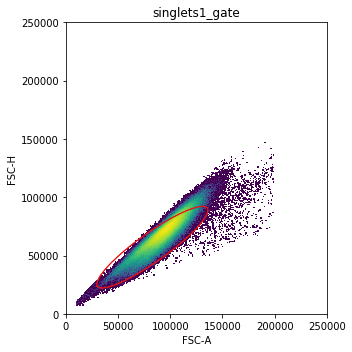

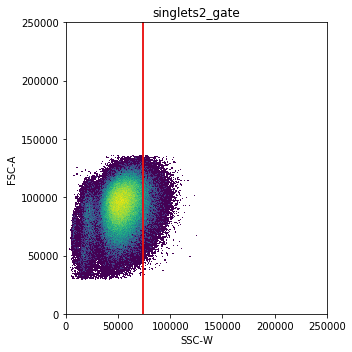

In [33]:
n = apply_template(samples[14], template='primary')

**FIX ME**

In [ ]:
n.clean('Single_Live_CD45+')
n.save(overwrite=True)

In [ ]:
n = apply_template(samples[15])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[16])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[17])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[18])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[19])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[20])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[21])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[22])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[23])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[24])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[25])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[26])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[27])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[28])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[29])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[30])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[31])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[32])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[33])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[34])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[35])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()

In [ ]:
n = apply_template(samples[36])

In [ ]:
n.clean('Single_Live_CD45+')
n.save()